In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import finnhub

finnhub_client = finnhub.Client(api_key=open('finnhub_api.txt','r').read())

start = 1584288249
end = 1611852249
zoom = pd.DataFrame(finnhub_client.stock_candles('ZM', 'D', _from=start, to=end))
zoom['Date'] = pd.to_datetime(zoom['t'], unit='s')
zoom.set_index('Date', inplace=True)
print(zoom.head())
print(zoom.tail())

tesla = pd.DataFrame(finnhub_client.stock_candles('TSLA', 'D', _from=start, to=end))
tesla['Date'] = pd.to_datetime(tesla['t'], unit='s')
tesla.set_index('Date', inplace=True)
print(tesla.head())
print(tesla.tail())
alphabet = pd.DataFrame(finnhub_client.stock_candles('GOOG', 'D', _from=start, to=end))
alphabet['Date'] = pd.to_datetime(alphabet['t'], unit='s')
alphabet.set_index('Date', inplace=True)
print(alphabet.head())
print(alphabet.tail())

                     c           h           l           o   s           t  \
Date                                                                         
2020-03-16  107.860001  119.870003  103.199997  105.000000  ok  1584316800   
2020-03-17  111.099998  113.830002  102.000000  107.330002  ok  1584403200   
2020-03-18  118.709999  119.000000  108.910004  111.019997  ok  1584489600   
2020-03-19  123.769997  132.220001  119.160004  122.019997  ok  1584576000   
2020-03-20  130.550003  135.979996  124.000000  129.000000  ok  1584662400   

                   v  
Date                  
2020-03-16  17210658  
2020-03-17  18721520  
2020-03-18  13594333  
2020-03-19  16248378  
2020-03-20  13872634  
                     c           h           l           o   s           t  \
Date                                                                         
2020-10-07  480.609985  487.369995  477.480011  482.500000  ok  1602028800   
2020-10-08  478.549988  489.230011  475.579987  485.350006

In [5]:
stocks = pd.concat([zoom['c'], tesla['c'], alphabet['c']], axis=1)
stocks.columns = ['Zoom', 'Tesla', 'Alphabet']
stocks.head()

,Zoom,Tesla,Alphabet
Date,,,
2020-03-16,107.860001,89.010002,1084.329956
2020-03-17,111.099998,86.040001,1119.800049
2020-03-18,118.709999,72.239998,1096.800049
2020-03-19,123.769997,85.529999,1115.290039
2020-03-20,130.550003,85.510002,1072.319946


In [6]:
log_r = np.log(stocks / stocks.shift(1))
log_r.head()

,Zoom,Tesla,Alphabet
Date,,,
2020-03-16,NaN,NaN,NaN
2020-03-17,0.029597,-0.033936,0.032188
2020-03-18,0.066253,-0.174818,-0.020753
2020-03-19,0.041741,0.168873,0.016718
2020-03-20,0.053331,-0.000234,-0.039290


In [7]:
np.random.seed(99)
weights = np.array(np.random.random(3))
weights = weights / np.sum(weights)

#Expected return for 252 trading days per year
exp_r = np.sum(log_r.mean() * weights) * 252

#Expected volatility
exp_v = np.sqrt(np.dot(weights.T, np.dot(log_r.cov() * 252, weights)))

#Sharpe ratio
sharpe = exp_r / exp_v

In [8]:
#Number of portfolios
num_ports = 1000

all_weights = np.zeros((num_ports, len(stocks.columns)))
r_arr = np.zeros(num_ports)
v_arr = np.zeros(num_ports)
sharpe_arr = np.zeros(num_ports)

for index in range(num_ports):
    weights = np.array(np.random.random(3))
    weights = weights / np.sum(weights)
    all_weights[index,:] = weights
    r_arr[index] = np.sum(log_r.mean() * weights) * 252
    v_arr[index] = np.sqrt(np.dot(weights.T, np.dot(log_r.cov() * 252, weights)))
    sharpe_arr[index] = r_arr[index] / v_arr[index]

sharpe_arr.max()

3.983221906133397

In [9]:
sharpe_arr.argmax()

876

In [10]:
all_weights[876, :]

array([0.38897228, 0.32408056, 0.28694716])

In [11]:
max_sharpe_r = r_arr[876]
max_sharpe_v = v_arr[876]
print(max_sharpe_r, max_sharpe_v)

2.1260667190640445 0.5337555298614697


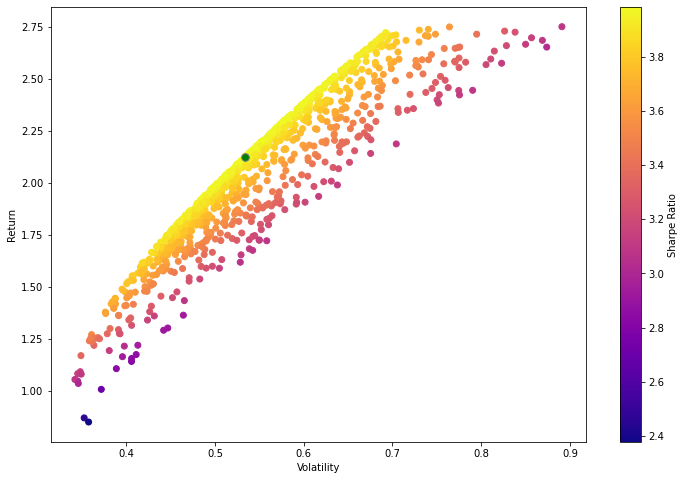

In [12]:
plt.figure(figsize=(12,8))
plt.scatter(v_arr, r_arr, c=sharpe_arr, cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')

#green dot for max sharpe ratio
plt.scatter(max_sharpe_v, max_sharpe_r, c='green', s=60, edgecolors='grey')

In [13]:
#Optimization

def get_rv_sharpe(weights):
    weights = np.array(weights)
    r = np.sum(log_r.mean() * weights) * 252
    v = np.sqrt(np.dot(weights.T, np.dot(log_r.cov() * 252, weights)))
    sharpe = r/v
    return np.array([r,v,sharpe])

In [14]:
from scipy.optimize import minimize

#Minimize negative sharpe
def neg_sharpe(weights):
    return get_rv_sharpe(weights)[2] * -1

#Constraints, return 0 if sum of weights is 1, minimize function conditions should return to 0 
def check_sum(weights):
    return np.sum(weights) - 1
con = ({'type':'eq', 'fun': check_sum})
bounds = ((0,1),(0,1),(0,1))
initial_guess = [0.33,0.33,0.34]

#Sequential least squares programming(SLSQP)
opt_results = minimize(neg_sharpe, initial_guess, method='SLSQP', bounds=bounds, constraints=con)
opt_results

     fun: -3.983486167008472
     jac: array([-0.00012574, -0.00098488,  0.00136992])
 message: 'Optimization terminated successfully'
    nfev: 22
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([0.390081  , 0.33480367, 0.27511533])

In [15]:
#Optimized weights, Sharpe ratios
print(opt_results.x, get_rv_sharpe(opt_results.x))

[0.390081   0.33480367 0.27511533] [2.15117467 0.54002313 3.98348617]


In [22]:
#Efficient frontier

#Returns go from 0 to 4
frontier_y = np.linspace(0,4,10)

def minimize_vol(weights):
    return get_rv_sharpe(weights)[1]

frontier_vol = [ ]
for poss_r in frontier_y:
    con = ({'type':'eq','fun': check_sum}, {'type':'eq', 'fun': lambda w: get_rv_sharpe(w)[0] - poss_r})
    result = minimize(minimize_vol, initial_guess, method='SLSQP', bounds=bounds, constraints=con)
    frontier_vol.append(result['fun'])

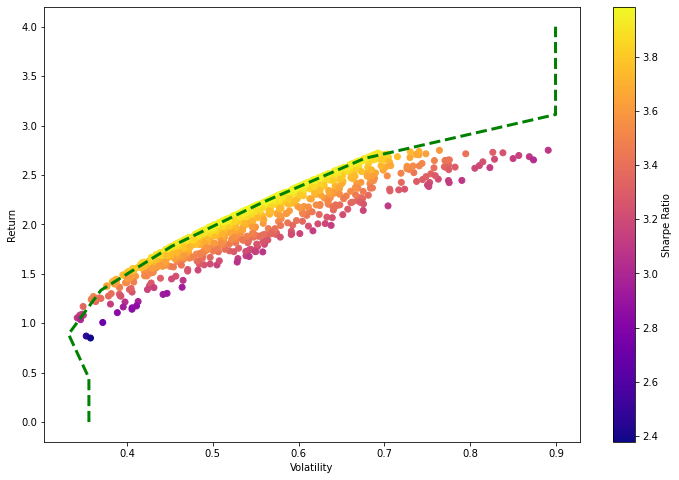

In [23]:
plt.figure(figsize=(12,8))
plt.scatter(v_arr, r_arr, c=sharpe_arr, cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')

#Add frontier to graph
plt.plot(frontier_vol, frontier_y, 'g--', linewidth=3);